<table width=100%>
    <col width=200>
    <tr>
        <td bgcolor="#eee" style="text-align:left" colspan="2">
            <font size="5"><b>Analysis of COVID-19 Infections and Death Data of Brazil</b></font></td>
    <tr>
    <tr>
        <td bgcolor="#eee" style="text-align:left"><b>Project creation date:</b> </td>
        <td bgcolor="#eee" style="text-align:left"> May 6, 2020 </td>
    </tr>
        <td bgcolor="#eee" style="text-align:left"><b>Dataset from Ministry of Health:</b> </td>
        <td bgcolor="#eee" style="text-align:left">  <a href="https://covid.saude.gov.br">https://covid.saude.gov.br</a> </td>
    </tr>
    <tr>
        <td bgcolor="#eee" style="text-align:left"><b>Project author:</b> </td>
        <td bgcolor="#eee" style="text-align:left"> Ricardo Szczerbacki (<a href="mailto:ricardo@rj1.info">ricardo@rj1.info</a>) </td>
    </tr>
    <tr>
        <td bgcolor="#eee" style="text-align:left"><b>Project on Github:</b></td>
        <td bgcolor="#eee" style="text-align:left"><a href="https://github.com/ricardocopa/Covid19">https://github.com/ricardocopa/Covid19</a></td>
    </tr>
    <tr>
        <td bgcolor="#eee" style="text-align:left"><b>License:</b></b></td>
        <td bgcolor="#eee" style="text-align:left"><a href="license.html">MIT License</a></td></a> 
    </tr>
    
</table>

In [1]:
import numpy as np
import pandas as pd
from IPython.display import HTML
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import locale
locale.setlocale(locale.LC_ALL, 'en_us.utf-8')

import warnings
warnings.filterwarnings('ignore')


In [2]:
    display(HTML('''
    <link rel="stylesheet" href="https://cdn.jupyter.org/notebook/5.1.0/style/style.min.css">
    <script>
        code_show=true; 
        
        function code_toggle() {
            if (code_show){
                $('div.input').hide();
            } else {
                $('div.input').show();
            }
            code_show = !code_show
        } 
        $( document ).ready(code_toggle);
    </script>
    
    Python source code is hidden by default for better visualization.
    To toggle source code visualization click <a href="javascript:code_toggle()">here</a>.'''))

### Loading Dataset
File __HIST_PAINEL_COVIDBR.xlsx__ downloaded from brazilian Ministry of Health <br>

In [3]:
datasetFileName = 'HIST_PAINEL_COVIDBR.xlsx'

In [4]:
html_code = '''
You can download the dataset file originally used by clicking <a href="http://covid.rj1.info/{}">here</a>
'''.format(datasetFileName)

display(HTML(html_code))

File contents (first 5 rows):

In [5]:
# how files where made available until May 10 2020 
# covid = pd.read_csv('arquivo_geral.csv', delimiter = ';') 
covidFull = pd.read_excel(datasetFileName, sheet_name='Sheet 1')
print('Columns: Region, State, City, State Code, City Code, Health Region Code, Health Region Name,  Date, Week, Population 2019, Total Infections, New Infections, Total Deaths, New Deaths, Total Recovered, New Patients')
display(covidFull.head())

# converting to the old file format
covid = covidFull[covidFull.estado.notnull()]
covid = covid[covid.codmun.isnull()]
covid.data = covid.data.dt.strftime('%Y-%m-%d')
covid = covid[['regiao', 'estado', 'data', 'casosNovos', 'casosAcumulado', 'obitosNovos', 'obitosAcumulado']]
covid.columns = ['regiao', 'estado', 'data', 'casosNovos', 'casosAcumulados', 'obitosNovos', 'obitosAcumulados'] 

# preparing a dataframe for the Rio de Janeiro city
covidRioDeJaneiro = covidFull.loc[covidFull['municipio'] == 'Rio de Janeiro']
covidRioDeJaneiro = covidRioDeJaneiro[['regiao', 'estado', 'data', 'casosNovos', 'casosAcumulado', 'obitosNovos', 'obitosAcumulado']]
covidRioDeJaneiro.columns = ['regiao', 'estado', 'data', 'casosNovos', 'casosAcumulados', 'obitosNovos', 'obitosAcumulados'] 


Columns: Region, State, City, State Code, City Code, Health Region Code, Health Region Name,  Date, Week, Population 2019, Total Infections, New Infections, Total Deaths, New Deaths, Total Recovered, New Patients


,regiao,estado,municipio,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,data,semanaEpi,populacaoTCU2019,casosAcumulado,casosNovos,obitosAcumulado,obitosNovos,Recuperadosnovos,emAcompanhamentoNovos,interior/metropolitana
0,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-25,9,210147125,0,0,0,0,NaN,NaN,NaN
1,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-26,9,210147125,1,1,0,0,NaN,NaN,NaN
2,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-27,9,210147125,1,0,0,0,NaN,NaN,NaN
3,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-28,9,210147125,1,0,0,0,NaN,NaN,NaN
4,Brasil,NaN,NaN,76,NaN,NaN,NaN,2020-02-29,9,210147125,2,1,0,0,NaN,NaN,NaN


### Some Information About the Dataset

In [6]:
firstDateData = datetime.strptime(covid['data'].min(), '%Y-%m-%d').strftime('%d/%m/%Y')  
lastDayData = datetime.strptime(covid['data'].max(), '%Y-%m-%d').strftime('%d/%m/%Y')  
numberOfDaysData = covid['data'].nunique()


covidMaxDeaths = covid.sort_values('obitosNovos', ascending = False).iloc[0]
maxDeathsValue = covidMaxDeaths['obitosNovos']
maxDeathsState = covidMaxDeaths['estado']
maxDeathsDay = datetime.strptime(covidMaxDeaths['data'], '%Y-%m-%d').strftime('%d/%m/%Y') 

covidRJ = covid.loc[covid['estado'] == 'RJ']
covidMaxDeathsRJ = covidRJ.sort_values('obitosNovos', ascending = False).iloc[0]
maxDeathsRJValue = covidMaxDeathsRJ['obitosNovos']
maxDeathsRJDay = datetime.strptime(covidMaxDeathsRJ['data'], '%Y-%m-%d').strftime('%d/%m/%Y') 

covidMaxDeathsBR = covid.groupby('data')['obitosNovos'].sum().reset_index(name ='obitosNovos')
covidMaxDeathsBR = covidMaxDeathsBR.sort_values('obitosNovos', ascending = False).iloc[0]
maxDeathsValueBR = covidMaxDeathsBR['obitosNovos']
maxDeathsDayBR = datetime.strptime(covidMaxDeathsBR['data'], '%Y-%m-%d').strftime('%d/%m/%Y') 

html_code = '''
<div style="
  background-color:LightGoldenRodYellow;
  border-style: solid;
  padding-top: 10px;
  padding-right: 10px;
  padding-bottom: 20px;
  padding-left: 10px;">
<img style="float: right;" width=30px, height=30px src="info2.png"> 
<p style="font-size:18px"> The file have data from <b>{}</b> to <b>{}</b></p>
<p style="font-size:18px"> <b>{}</b> was the state with the greater number of deaths in one day. There were <b>{:n}</b> deaths on <b>{}</b>. </p>
<p style="font-size:18px"> The day with the greater number of deaths in <b>RJ</b> happend on <b>{}</b>, with a total of <b>{:n}</b> deaths registered. </p>
<p style="font-size:18px"> The day with the greater number of deaths all over Brazil happend on <b>{}</b>, with a total of <b>{:n}</b> deaths registered. </p>
<p style="font-size:18px"> <b>PS</b>: All dates in this page are displayed in the format: DD/MM/YYYY</p>
</div>

'''.format(firstDateData, lastDayData, maxDeathsState, maxDeathsValue, maxDeathsDay, maxDeathsRJDay, maxDeathsRJValue, maxDeathsDayBR, maxDeathsValueBR)

display(HTML(html_code))



In [7]:
# Creating normalized columns for infections and deaths by dividing it by the population multiplied by a million (cases per million people). Source for brazilian population data: IBGE population estimation for 2019
# https://pt.wikipedia.org/wiki/Lista_de_unidades_federativas_do_Brasil_por_popula%C3%A7%C3%A3o

data = {'state': ['AC','AL','AP','AM','BA','CE','DF',
                   'ES','GO','MA','MT','MS','MG','PA',
                   'PB','PR','PE','PI','RJ','RN','RS',
                   'RO','RR','SC','SP','SE','TO'],
        'population': [881935, 3337357, 845731, 4144597, 14873064, 9132078, 3015268, 
                       4018650, 7018354, 7075181, 3484466, 2778986, 21168791, 8602865,
                       4018127, 11433957, 9557071, 3273227, 17264943, 3506853, 11377239,
                       1777225, 605761, 7164788, 45919049, 2298696, 1572866]
       }

populationByState = pd.DataFrame (data, columns = ['state','population'])

covid = covid.merge(populationByState, left_on='estado', right_on='state')

covid['normTotalInfections'] = covid['casosAcumulados']/covid['population'] * 1000000.
covid['normTotalDeaths'] = covid['obitosAcumulados']/covid['population'] * 1000000.


### Infections and  deaths in Brazil and Rio de Janeiro

In [8]:
lastDay = covid['data'].max()
lastDayFormatted = datetime.strptime(lastDay, '%Y-%m-%d').strftime('%d/%m/%Y')

covidLastDay = covid.loc[covid['data'] == lastDay]

infectionsBR = covidLastDay.sum()['casosAcumulados']
deathsBR = covidLastDay.sum()['obitosAcumulados']
infectionsLastDayBR = covidLastDay.sum()['casosNovos']
deathsLastDayBR = covidLastDay.sum()['obitosNovos']

covidRJ = covidLastDay.loc[covid['estado'] == 'RJ']

infectionsLastDayRJ = covidRJ.sum()['casosNovos']
deathsLastDayRJ = covidRJ.sum()['obitosNovos']
infectionsRJ = covidRJ.sum()['casosAcumulados']
deathsRJ = covidRJ.sum()['obitosAcumulados']

html_code = '''
<div style="
  background-color:LightGoldenRodYellow;
  border-style: solid;
  padding-top: 10px;
  padding-right: 10px;
  padding-bottom: 20px;
  padding-left: 10px;">
<img style="float: right;" width=30px, height=30px src="info2.png"> 
<p style="font-size:18px"> <b>{}</b> is the last day in the dataset.</p>
<p>
<p style="font-size:18px"> <b>{:n} infections</b> were confirmed in <b>Brazil</b> on this day, of <b>{:n} total infections</b>. </p>
<p style="font-size:18px"> <b>{:n} deaths</b> were confirmed in <b>Brazil</b> on this day, of <b>{:n} total deaths</b>. </p>
<p>
<p style="font-size:18px"> <b>{:n} infections</b> were confirmed in <b>RJ</b> on this day, of <b>{:n} total infections</b>. </p>
<p style="font-size:18px"> <b>{:n} deaths</b> were confirmed in <b>RJ</b> on this day, of <b>{:n} total deaths</b>. </p>
</div>

'''.format(lastDayFormatted, infectionsLastDayBR, infectionsBR, deathsLastDayBR, deathsBR,
          infectionsLastDayRJ, infectionsRJ, deathsLastDayRJ, deathsRJ)

display(HTML(html_code))


In [9]:
covidLastDay = covidLastDay[['estado','casosAcumulados', 'obitosAcumulados', 'normTotalInfections', 'normTotalDeaths']]
covidLastDay.sort_values('normTotalDeaths', ascending=False, inplace=True)
covidLastDay.set_index('estado', inplace=True)
covidLastDay2 = covidLastDay.copy()
covidLastDay2.columns = ['Infections', 'Deaths', 'Infections/MM inh.', 'Deaths/MM inh.']

In [10]:
html_code = '''
<div style="
  background-color:LightGoldenRodYellow;
  border-style: solid;
  padding-top: 10px;
  padding-right: 10px;
  padding-bottom: 40px;
  padding-left: 10px;">
<img style="float: right;" width=30px, height=30px src="info2.png"> 
<h2> Infections and deaths by state </h2>
<p style="font-size:18px"> Sorted by the severity (deaths per million people). States in worst situation are near the top. </p>
<p style="font-size:18px"> The k-means method was used for clustering the states in 3 classes of severity. </p>
</div>
'''
display(HTML(html_code))

In [11]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)

covidLastDay['myClass'] = kmeans.fit_predict(covidLastDay[['normTotalDeaths']])

In [12]:
worstClass = covidLastDay.iloc[0]['myClass']
bestClass = covidLastDay.iloc[-1]['myClass']

def highlight(s):
    tamanho = s.size
    if s.myClass == worstClass:
        return ['background-color: orange']*tamanho
    elif s.myClass != bestClass:
        return ['background-color: yellow']*tamanho
    else:
        return ['background-color: white']*tamanho

covidLastDay.reset_index(inplace=True)

covidLastDay2 = covidLastDay.copy()

covidLastDay2.columns=['State', 'Infections', 'Deaths', 'Infections/MM inhab.', 'Deaths/MM inhab.', 'myClass']

display(covidLastDay2.style.apply(highlight, axis=1))

    

,State,Infections,Deaths,Infections/MM inhab.,Deaths/MM inhab.,myClass
0,CE,153108,7317,16766,801.242,0
1,AM,92721,3183,22371.5,767.988,0
2,RR,26954,451,44496.1,744.518,0
3,RJ,148623,12443,8608.37,720.709,0
4,PA,142358,5581,16547.7,648.737,0
5,PE,81382,6152,8515.37,643.712,0
6,AP,34660,544,40982.3,643.231,0
7,ES,73688,2305,18336.5,573.576,0
8,AC,17979,470,20385.9,532.919,2
9,SE,48140,1211,20942.3,526.82,2


### Comparing Infections and Deaths by State
Using absolute values

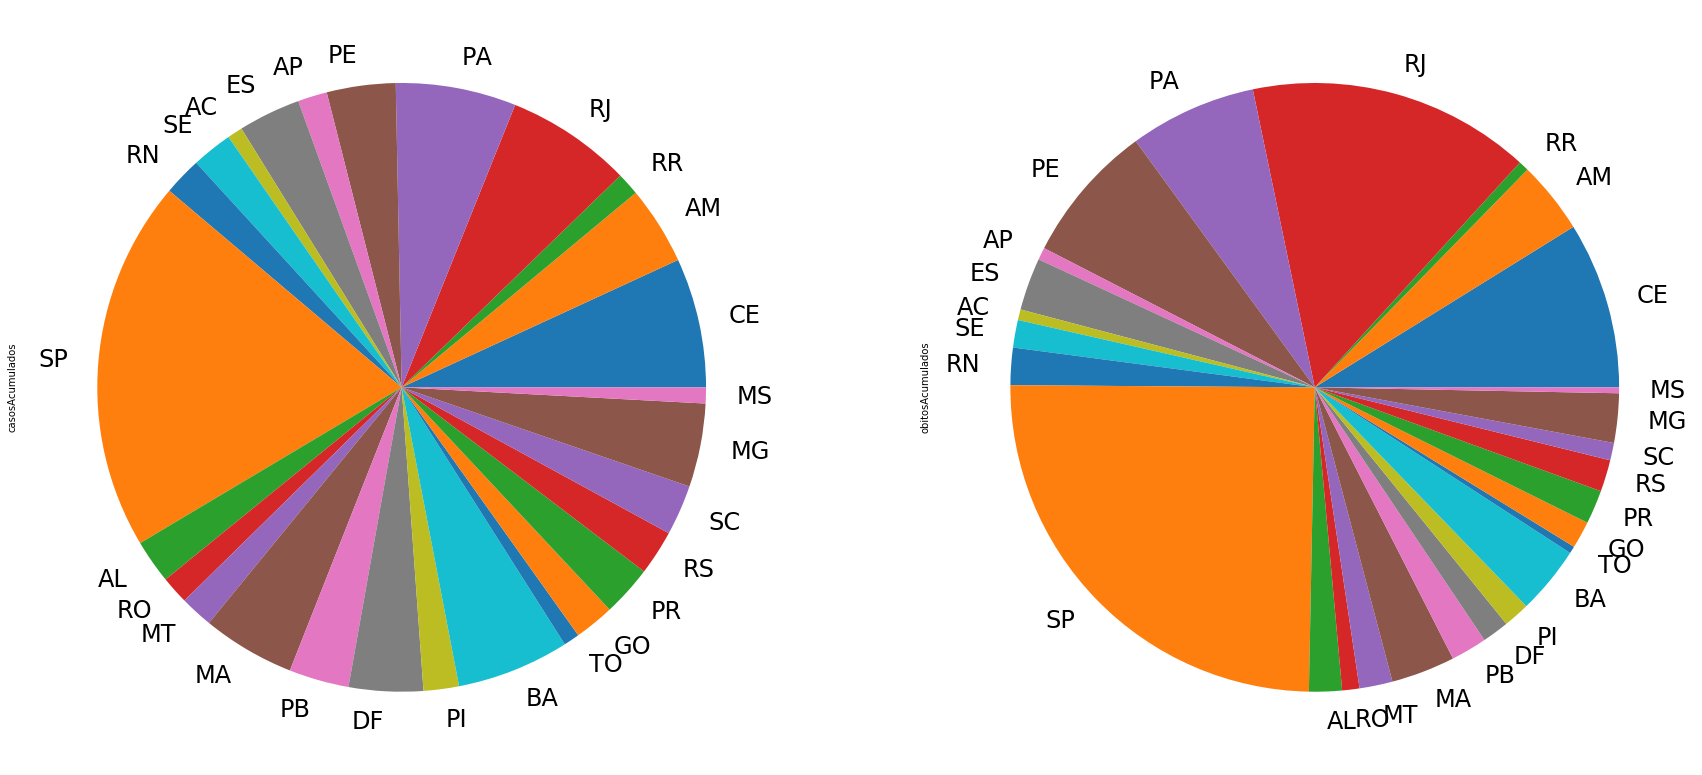

In [13]:
covidLastDayPie1 = covidLastDay[['estado','casosAcumulados', 'obitosAcumulados']]
covidLastDayPie1.set_index('estado', inplace=True)
plot = covidLastDayPie1.plot.pie(fontsize=24, subplots=True, layout=(1, 2), figsize=(30, 15), legend=None)

### Comparing Infections and Deaths per Million Inhabitans, per State

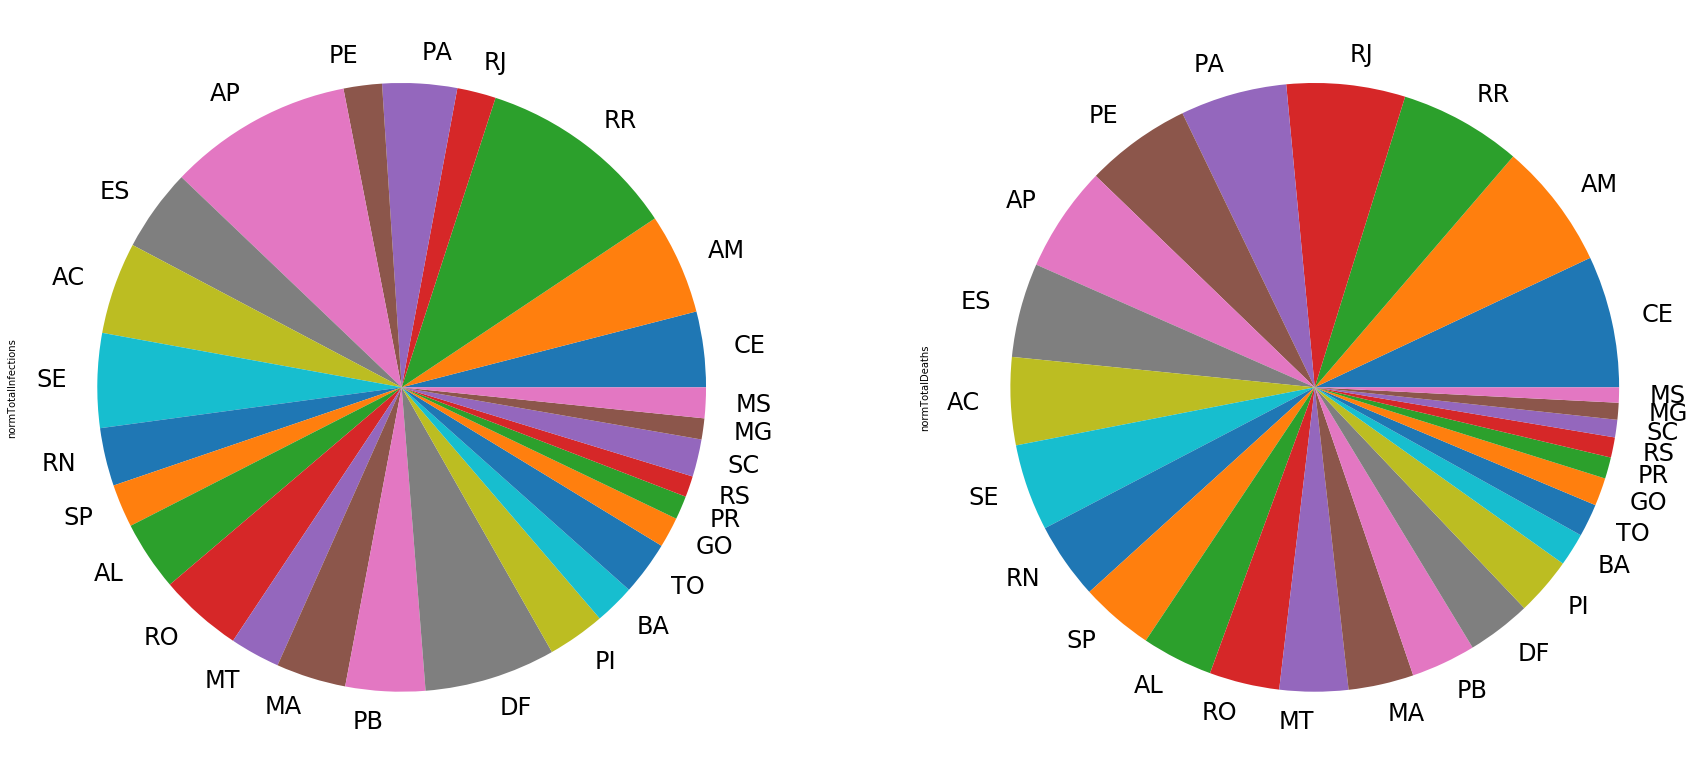

In [14]:
covidLastDayPie2 = covidLastDay[['estado','normTotalInfections', 'normTotalDeaths']]
covidLastDayPie2.set_index('estado', inplace=True)
plot = covidLastDayPie2.plot.pie(fontsize=24, subplots=True, layout=(1, 2), figsize=(30, 15), legend=None)

### Plots of cumulative infections and deaths

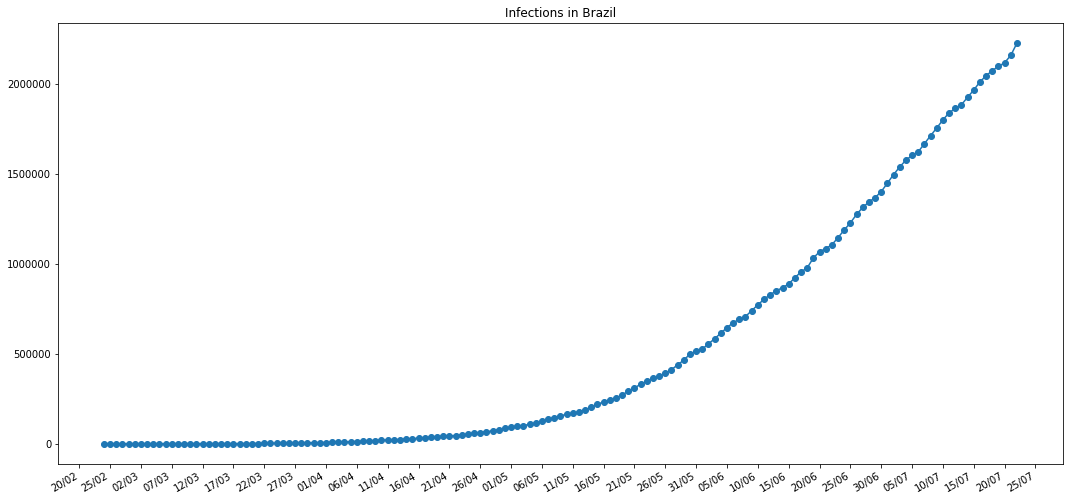

In [15]:
covid['data'] = pd.to_datetime(covid['data'], format='%Y-%m-%d')

covidByDayBR = covid[['data', 'casosAcumulados', 'obitosAcumulados']].groupby('data').sum()
covidByDayBR.reset_index(inplace=True)
covidByDayBR.set_index(['data'],inplace=True)

covidByDayRJ = covid.loc[covid['estado'] == 'RJ'][['data', 'casosAcumulados', 'obitosAcumulados', 'normTotalInfections', 'normTotalDeaths']]
covidByDayRJ.reset_index(inplace=True)
covidByDayRJ.set_index(['data'],inplace=True)

axis = covidByDayBR.plot(legend=False, style='o-', figsize=(18, 9), y='casosAcumulados', title='Infections in Brazil')
plt.gcf().autofmt_xdate()
plt.minorticks_off()
axis.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
axis.xaxis.set_major_locator(mdates.DayLocator(interval=5))
axis.xaxis.get_label().set_visible(False)

plt.show()

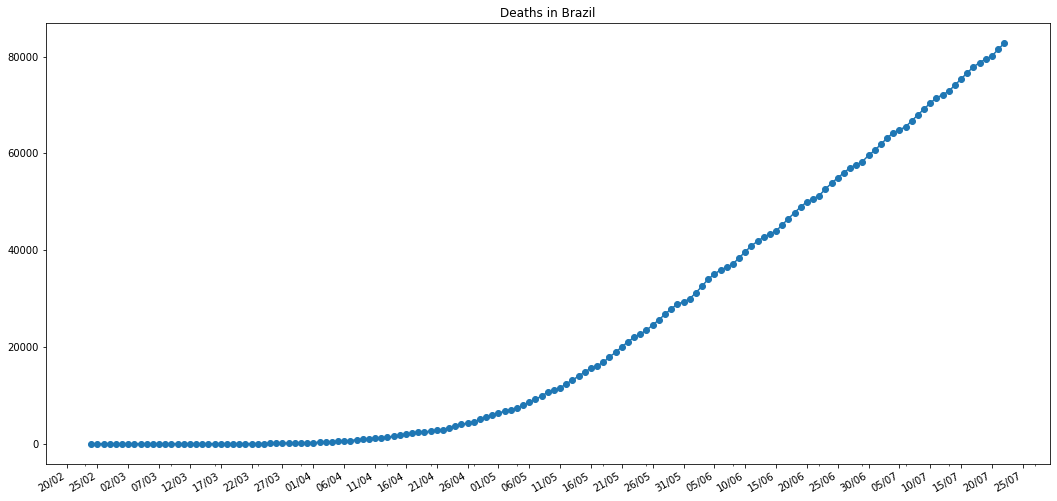

In [16]:
axis = covidByDayBR.plot(legend=False, style='o-',figsize=(18, 9), y='obitosAcumulados', title='Deaths in Brazil')
plt.gcf().autofmt_xdate()
axis.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
axis.xaxis.set_major_locator(mdates.DayLocator(interval=5))
axis.xaxis.get_label().set_visible(False)

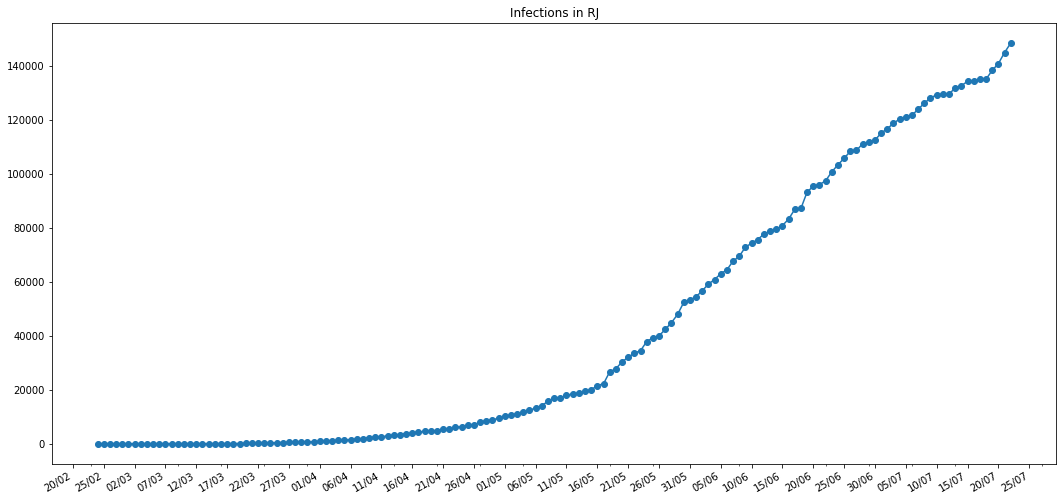

In [17]:
axis = covidByDayRJ.plot(legend=False,style='o-',figsize=(18, 9), y='casosAcumulados', title='Infections in RJ')
plt.gcf().autofmt_xdate()
axis.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
axis.xaxis.set_major_locator(mdates.DayLocator(interval=5))
axis.xaxis.get_label().set_visible(False)

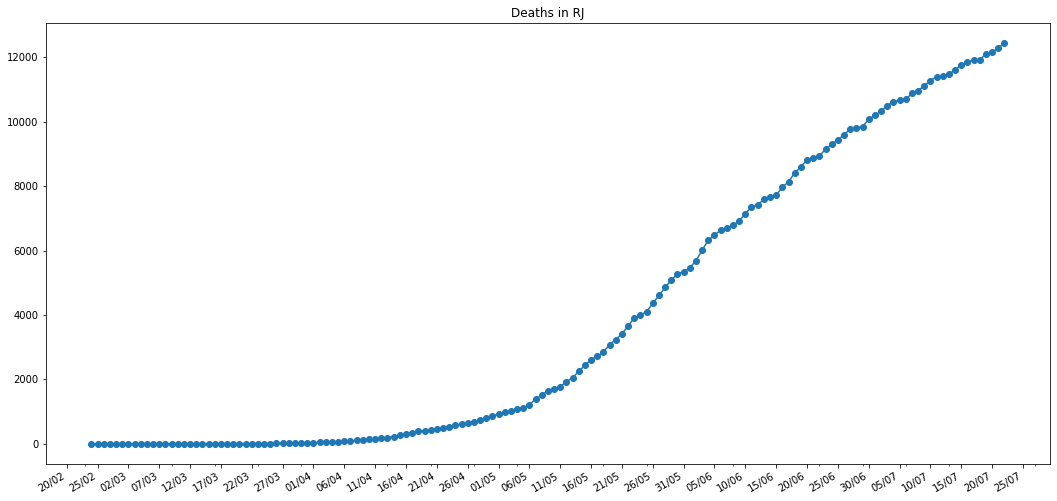

In [18]:
axis = covidByDayRJ.plot(legend=False, style='o-',figsize=(18, 9), y='obitosAcumulados', title='Deaths in RJ')
plt.gcf().autofmt_xdate()
axis.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
axis.xaxis.set_major_locator(mdates.DayLocator(interval=5))
axis.xaxis.get_label().set_visible(False)

### Plots of new deaths for Brazil, RJ state and Rio de Janeiro city
Rolling mean of the last 7 days for the new deaths by day.

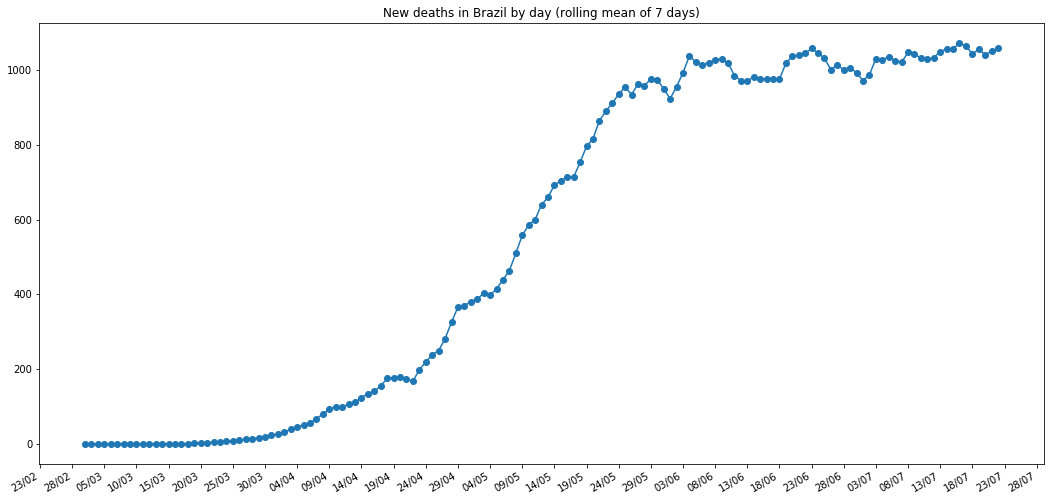

In [19]:
newCovidByDayBR = covid[['data', 'obitosNovos']].groupby('data').sum()
newCovidByDayBR.reset_index(inplace=True)
newCovidByDayBR.set_index(['data'],inplace=True)
newCovidByDayBR['rollingNewDeaths'] = newCovidByDayBR['obitosNovos'].rolling(window=7).mean()

axis = newCovidByDayBR.plot(legend=False, style='o-', figsize=(18, 9), y='rollingNewDeaths', title='New deaths in Brazil by day (rolling mean of 7 days)')
plt.gcf().autofmt_xdate()
plt.minorticks_off()
axis.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
axis.xaxis.set_major_locator(mdates.DayLocator(interval=5))
axis.xaxis.get_label().set_visible(False)

plt.show()

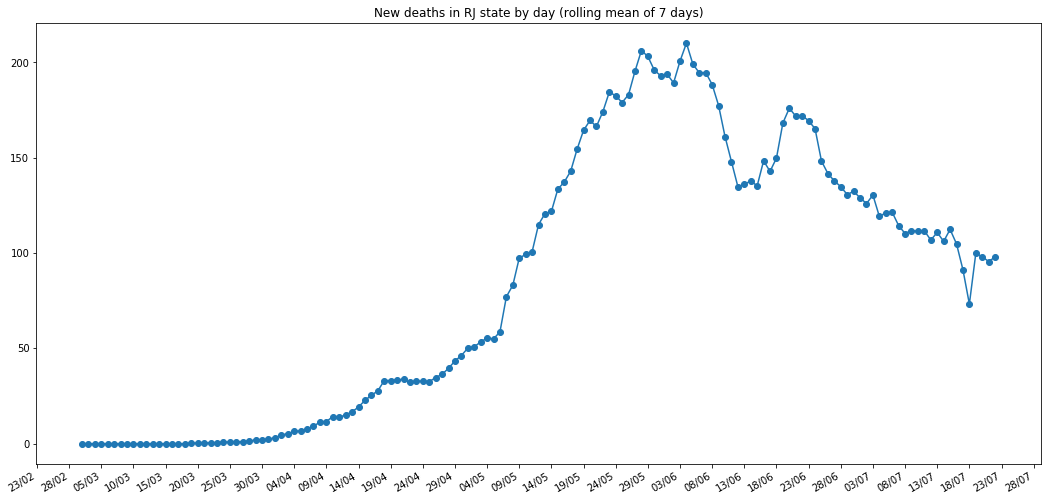

In [20]:
newCovidByDayRJ = covid.loc[covid['estado'] == 'RJ'][['data', 'obitosNovos']]
newCovidByDayRJ.reset_index(inplace=True)
newCovidByDayRJ.set_index(['data'],inplace=True)
newCovidByDayRJ['rollingNewDeaths'] = newCovidByDayRJ['obitosNovos'].rolling(window=7).mean()

axis = newCovidByDayRJ.plot(legend=False, style='o-', figsize=(18, 9), y='rollingNewDeaths', title='New deaths in RJ state by day (rolling mean of 7 days)')
plt.gcf().autofmt_xdate()
plt.minorticks_off()
axis.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
axis.xaxis.set_major_locator(mdates.DayLocator(interval=5))
axis.xaxis.get_label().set_visible(False)

plt.show()

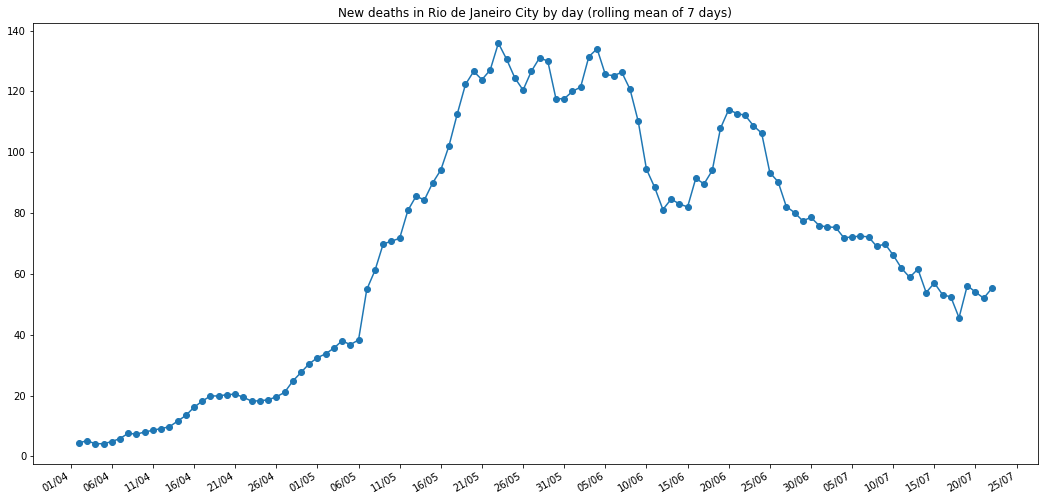

In [21]:
newCovidByDayRio = covidRioDeJaneiro[['data', 'obitosNovos']]
newCovidByDayRio.reset_index(inplace=True)
newCovidByDayRio.set_index(['data'],inplace=True)
newCovidByDayRio['rollingNewDeaths'] = newCovidByDayRio['obitosNovos'].rolling(window=7).mean()

axis = newCovidByDayRio.plot(legend=False, style='o-', figsize=(18, 9), y='rollingNewDeaths', title='New deaths in Rio de Janeiro City by day (rolling mean of 7 days)')
plt.gcf().autofmt_xdate()
plt.minorticks_off()
axis.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
axis.xaxis.set_major_locator(mdates.DayLocator(interval=5))
axis.xaxis.get_label().set_visible(False)

plt.show()


### Comparing tendencies of all states in the last 10 days
For the log of the deaths data of the last 10 days for all states, I use Linear Regressions to estimate and compare how the situation is evolving. Higher coefficients means that situation is getting worse. 

In [22]:
deathsByDayStates = covid.pivot(index='data', columns='estado', values = 'normTotalDeaths')

last10Days = deathsByDayStates.tail(10)

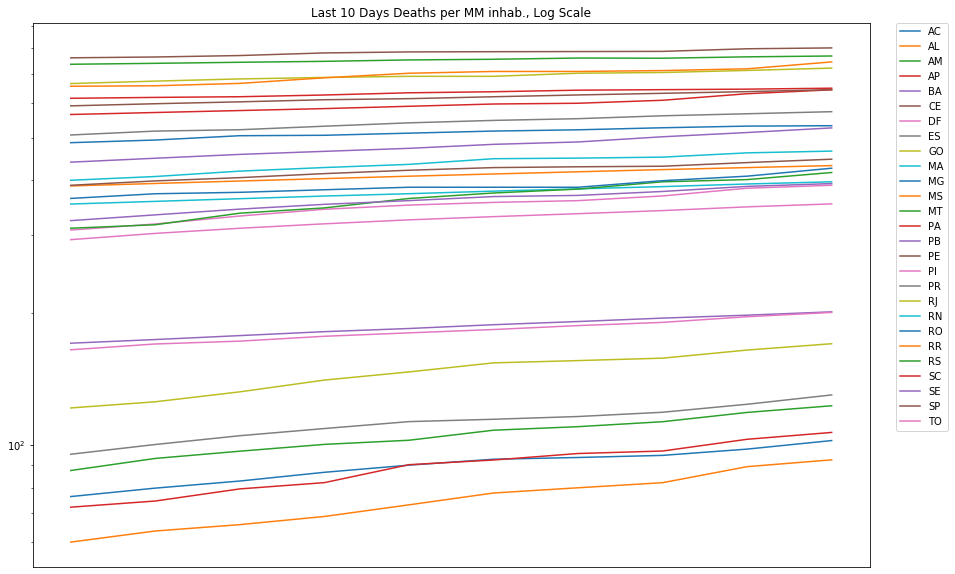

In [23]:
axis = last10Days.plot(logy=True, figsize=(15,10), title='Last 10 Days Deaths per MM inhab., Log Scale').legend(bbox_to_anchor=(1.1, 1.01))
plt.gca().xaxis.get_label().set_visible(False)
plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False) 
plt.show()

In [24]:
last10Days['day'] = range(1,11)

X_train = last10Days['day']
X_train = X_train.values.reshape(-1, 1)

data = {'state': [],
        'coefficient': []
       }
coef10days = pd.DataFrame (data, columns = ['state','coefficient'])


In [25]:
from sklearn.linear_model import LinearRegression

regression_model = LinearRegression()

# Evaluating coefficients 
for col in last10Days.columns: 
    if col != 'day':
        last10Days[col + 'log'] = np.log(last10Days[col])
        regression_model.fit(X_train, last10Days[col + 'log'])
        coef10days = coef10days.append(pd.Series([col, regression_model.coef_[0]], index=coef10days.columns), ignore_index=True)



In [26]:
html_code = '''
<div style="
  background-color:LightGoldenRodYellow;
  border-style: solid;
  padding-top: 10px;
  padding-right: 10px;
  padding-bottom: 40px;
  padding-left: 10px;">
<img style="float: right;" width=30px, height=30px src="info2.png"> 
<h2> Predictions for the Near Future </h2>
<p style="font-size:18px"> Using the linear regression over the log data to estimate the number of deaths in 7, 14 e 30 days. </p>
</div>
'''
display(HTML(html_code))

#### All States

In [27]:
from datetime import timedelta

data = {'date': [],
        'state': [],
        'predictedDeaths': []
       }
predictedDeaths = pd.DataFrame (data, columns = ['date','state', 'predictedDeaths'])

more7Days = 17;
more14Days = 24;
more30Days = 40;
dateMore7Days = (datetime.strptime(lastDay, '%Y-%m-%d') + timedelta(days=7)).strftime("%d/%m/%Y")
dateMore14Days = (datetime.strptime(lastDay, '%Y-%m-%d') + timedelta(days=14)).strftime("%d/%m/%Y")
dateMore30Days = (datetime.strptime(lastDay, '%Y-%m-%d') + timedelta(days=30)).strftime("%d/%m/%Y")

deathsByState = covid.pivot(index='data', columns='estado', values = 'obitosAcumulados')
last10Days = deathsByState.tail(10)
last10Days['day'] = range(1,11)

for col in last10Days.columns: 
    if col != 'day':
        last10Days[col + 'log'] = np.log(last10Days[col])
        regression_model.fit(X_train, last10Days[col + 'log'])
        
        xpredict = np.array([more7Days])
        xpredict = xpredict.reshape(-1,1)
        prediction = regression_model.predict(xpredict)
        predictedDeaths = predictedDeaths.append(pd.Series([dateMore7Days, col, int(np.exp(prediction[0]))], index=predictedDeaths.columns), ignore_index=True)
        
        xpredict = np.array([more14Days])
        xpredict = xpredict.reshape(-1,1)
        prediction = regression_model.predict(xpredict)
        predictedDeaths = predictedDeaths.append(pd.Series([dateMore14Days, col, int(np.exp(prediction[0]))], index=predictedDeaths.columns), ignore_index=True)
        
        xpredict = np.array([more30Days])
        xpredict = xpredict.reshape(-1,1)
        prediction = regression_model.predict(xpredict)
        predictedDeaths = predictedDeaths.append(pd.Series([dateMore30Days, col, int(np.exp(prediction[0]))], index=predictedDeaths.columns), ignore_index=True)
        
predictedDeaths
predictedDeathsOut = predictedDeaths.pivot(index='state', columns='date', values = 'predictedDeaths')

predictedDeathsOut = predictedDeathsOut[[dateMore7Days, dateMore14Days, dateMore30Days]]

predictedDeathsBrazil = predictedDeathsOut.sum().reset_index(name='predictedDeaths')
predictedDeathsBrazil = predictedDeathsBrazil.append(pd.Series([lastDayFormatted, deathsBR], index=predictedDeathsBrazil.columns), ignore_index=True)
predictedDeathsBrazil.set_index('date', inplace=True)
predictedDeathsBrazilOut = predictedDeathsBrazil.transpose()
predictedDeathsBrazilOut = predictedDeathsBrazilOut[[lastDayFormatted, dateMore7Days, dateMore14Days, dateMore30Days]]

predictedDeathsOut['state'] = predictedDeathsOut.index
covidLastDayOut = covidLastDay[['estado', 'obitosAcumulados']][['estado', 'obitosAcumulados']]
covidLastDayOut
predictedDeathsOut = predictedDeathsOut.merge(covidLastDayOut, left_on='state', right_on='estado')
predictedDeathsOut = predictedDeathsOut[['estado', 'obitosAcumulados', dateMore7Days, dateMore14Days, dateMore30Days]]
predictedDeathsOut.columns = ['State', lastDayFormatted, dateMore7Days, dateMore14Days, dateMore30Days]

pd.options.display.float_format = '{0:g}'.format
display(predictedDeathsOut)





,State,22/07/2020,29/07/2020,05/08/2020,21/08/2020
0,AC,470,507,543,635
1,AL,1443,1571,1707,2065
2,AM,3183,3294,3406,3677
3,AP,544,588,646,801
4,BA,2988,3404,3868,5179
5,CE,7317,7599,7895,8615
6,DF,1176,1406,1673,2490
7,ES,2305,2544,2796,3472
8,GO,1193,1573,2043,3714
9,MA,2810,3079,3370,4144


#### Brazil

In [28]:
predictedDeathsBrazilOut.columns = [lastDayFormatted, dateMore7Days, dateMore14Days, dateMore30Days]
predictedDeathsBrazilOut.reset_index(inplace=True)
predictedDeathsBrazilOut.drop('index', axis=1, inplace=True)
display(predictedDeathsBrazilOut)

,22/07/2020,29/07/2020,05/08/2020,21/08/2020
0,82771,91447,101352,130335


In [29]:
coef10days.sort_values('coefficient',ascending=False,inplace=True)
coef10days.set_index('state', inplace=True)

In [30]:
html_code = '''
<div style="
  background-color:LightGoldenRodYellow;
  border-style: solid;
  padding-top: 10px;
  padding-right: 10px;
  padding-bottom: 40px;
  padding-left: 10px;">
<img style="float: right;" width=30px, height=30px src="info2.png"> 
<h2> Clustering the states in 3 classes according to the calculated coefficients </h2>
<p style="font-size:18px">  A higher coefficient means a worse tendency for the deaths. </p>
</div>
'''
display(HTML(html_code))

In [31]:
coef10daysData = pd.DataFrame(coef10days)
coef10daysData['state'] = coef10daysData.index
coef10daysData = coef10daysData.reset_index(level=0, drop=True)
coef10daysData = coef10daysData[['state', 'coefficient']]

coef10daysData['myClass'] = kmeans.fit_predict(coef10daysData[['coefficient']])
worstClass = coef10daysData.iloc[0]['myClass']
bestClass = coef10daysData.iloc[-1]['myClass']

display(coef10daysData.style.apply(highlight, axis=1))

,state,coefficient,myClass
0,MS,0.0475956,0
1,SC,0.0440414,0
2,GO,0.0373562,0
3,RS,0.0354276,0
4,MT,0.0329215,0
5,PR,0.0308451,0
6,MG,0.0303583,0
7,DF,0.024851,2
8,TO,0.0208404,2
9,PB,0.0207044,2


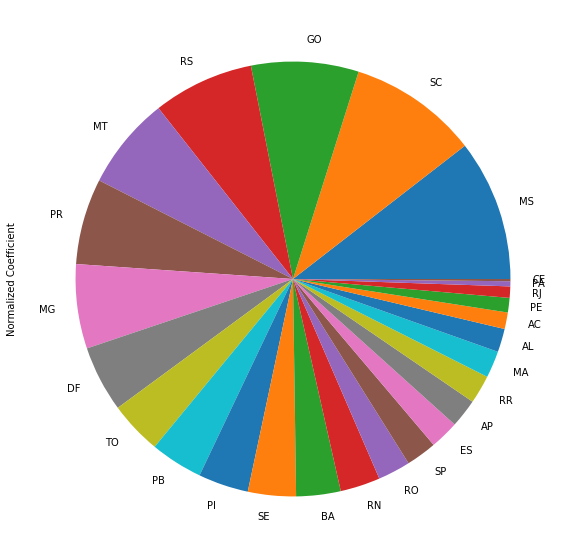

In [32]:
coef10days['Normalized Coefficient'] = (coef10days['coefficient']-coef10days['coefficient'].min())/(coef10days['coefficient'].max()-coef10days['coefficient'].min())

_ = coef10days.plot.pie(y='Normalized Coefficient', figsize=(10, 10), legend=False)

### R curve
Estimating R, that represents the basic reproduction rate of the disease. It roughly estimates how many people are infected by one infected person after 14 days, assuming a constant death rate for the infected.

It is a very simple and imprecise approach. And, specially, the values in the begining of the plot should be disregarded, because the first notifications of the infections are not representative or reliable.

The plot is more of a tendency indicator, than a real value estimator. 

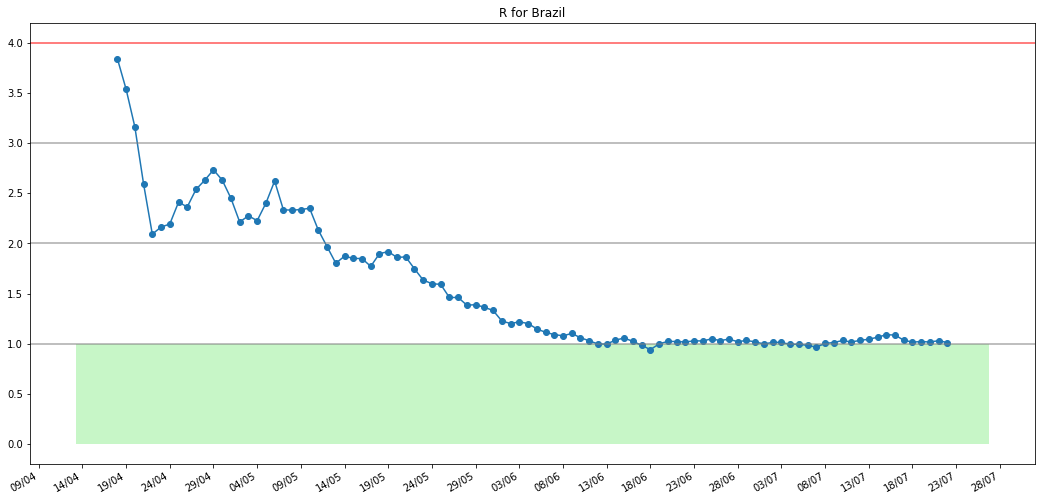

In [33]:

data = {'date': [],
        'value': []
       }
R_Brazil = pd.DataFrame (data, columns = ['date','value'])

# Generation Time
gt = 14

covidDeathsBR = covid.groupby('data')['obitosNovos'].sum().reset_index(name ='obitosNovos')
covidDeathsBR['rollingMean'] =covidDeathsBR['obitosNovos'].rolling(window=7).mean()

for day in range(covidDeathsBR.shape[0]):
    if day >= gt:
        if covidDeathsBR.at[day-gt,'rollingMean'] > 0:
            Rvalue = float(covidDeathsBR.at[day,'rollingMean'])/float(covidDeathsBR.at[day-gt,'rollingMean'])
            if Rvalue <= 4:
                R_Brazil = R_Brazil.append(pd.Series([covidDeathsBR.at[day, 'data'], Rvalue], index=R_Brazil.columns), ignore_index=True)

R_Brazil['date'] = pd.to_datetime(R_Brazil['date'], format='%Y-%m-%d')

R_Brazil.set_index('date', inplace=True)
axis = R_Brazil.plot(style='o-', figsize=(18, 9), legend=False, y='value', title='R for Brazil')
plt.gcf().autofmt_xdate()
plt.minorticks_off()
axis.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
axis.xaxis.set_major_locator(mdates.DayLocator(interval=5))
axis.axhline(1.0, color='gray', lw=2, alpha=0.5)
axis.axhline(2.0, color='gray', lw=2, alpha=0.5)
axis.axhline(3.0, color='gray', lw=2, alpha=0.5)
axis.axhline(4.0, color='red', lw=2, alpha=0.5)
axis.fill_between(axis.get_xlim(), 0., 1., facecolor='lightgreen', alpha=0.5)
axis.xaxis.get_label().set_visible(False)
plt.show()




In [34]:
data = {'date': [],
        'state': [],
        'value': []
       }
R_States = pd.DataFrame (data, columns = ['date','state', 'value'])

for state in covid.estado.unique():
    covidState = covid.loc[covid['estado'] == state]

    covidDeathsState = covidState.groupby('data')['obitosNovos'].sum().reset_index(name ='obitosNovos')
    covidDeathsState['rollingMean'] =covidDeathsState['obitosNovos'].rolling(window=7).mean()
    for day in range(covidDeathsState.shape[0]):
        if day >= gt:
            if covidDeathsState.at[day-gt,'rollingMean'] > 0:
                Rvalue = float(covidDeathsState.at[day,'rollingMean'])/float(covidDeathsState.at[day-gt,'rollingMean'])
                R_States = R_States.append(pd.Series([covidDeathsState.at[day, 'data'], state, Rvalue], index=R_States.columns), ignore_index=True)


R_States['date'] = pd.to_datetime(R_States['date'], format='%Y-%m-%d')

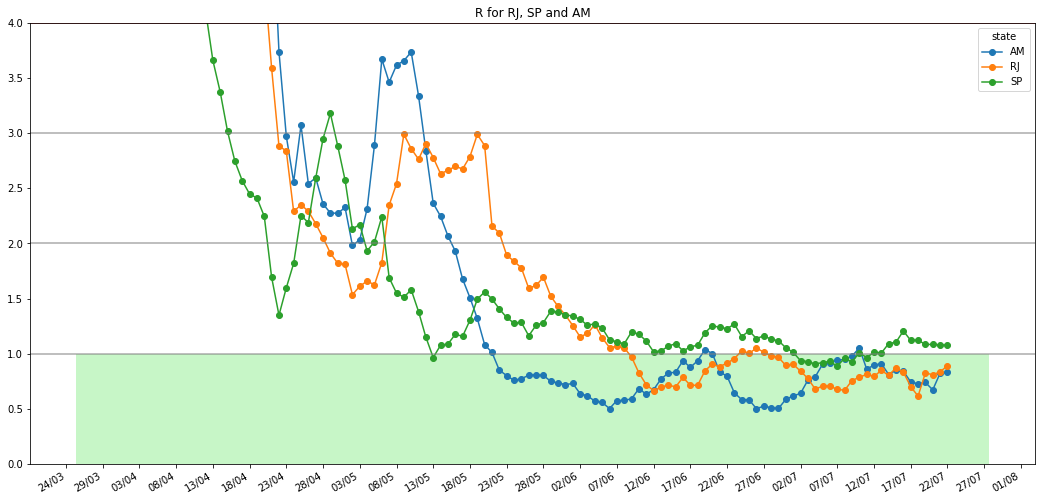

In [35]:
R_StatesGroup = R_States.loc[R_States['state'].isin(['RJ', 'SP', 'AM'])]
R_StatesGroup = R_StatesGroup.pivot(index='date', columns='state', values = 'value')

axis = R_StatesGroup.plot(style='o-', figsize=(18, 9), title='R for RJ, SP and AM')
plt.gcf().autofmt_xdate()
plt.minorticks_off()
axis.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
axis.xaxis.set_major_locator(mdates.DayLocator(interval=5))
axis.axhline(1.0, color='gray', lw=2, alpha=0.5)
axis.axhline(2.0, color='gray', lw=2, alpha=0.5)
axis.axhline(3.0, color='gray', lw=2, alpha=0.5)
axis.axhline(4.0, color='red', lw=2, alpha=0.5)
axis.fill_between(axis.get_xlim(), 0., 1., facecolor='lightgreen', alpha=0.5)
plt.ylim((0,4))
axis.xaxis.get_label().set_visible(False)
_ = plt.show()